## Dataset Details

amount_tsh — Total static head (amount water available to waterpoint)

date_recorded — The date the row was entered

funder — Who funded the well

gps_height — Altitude of the well

installer — Organization that installed the well

longitude — GPS coordinate

latitude — GPS coordinate

wpt_name — Name of the waterpoint if there is one

num_private — No information

basin — Geographic water basin

subvillage — Geographic location

region — Geographic location

region_code — Geographic location (coded)

district_code — Geographic location (coded)

lga — Geographic location

ward — Geographic location

population — Population around the well

public_meeting — True/False

recorded_by — Group entering this row of data

scheme_management — Who operates the waterpoint

scheme_name — Who operates the waterpoint

permit — If the waterpoint is permitted

construction_year — Year the waterpoint was constructed

extraction_type — The kind of extraction the waterpoint uses

extraction_type_group — The kind of extraction the waterpoint uses

extraction_type_class — The kind of extraction the waterpoint uses

management — How the waterpoint is managed

management_group — How the waterpoint is managed

payment — What the water costs

payment_type — What the water costs

water_quality — The quality of the water

quality_group — The quality of the water

quantity — The quantity of water

quantity_group — The quantity of water (duplicates quality)

source — The source of the water

source_type — The source of the water

source_class — The source of the water

waterpoint_type — The kind of waterpoint

waterpoint_type_group — The kind of waterpoint

In [175]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression

In [176]:
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import (
    ColumnDataSource, GMapOptions, LinearColorMapper,
    FactorRange, ColorBar, BasicTicker, PrintfTickFormatter
)
from bokeh.palettes import Spectral3, Spectral6, Spectral7
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.plotting import gmap
from bokeh.layouts import gridplot, row

output_notebook()

## Load Datasets

In [177]:
#get training data
df_train = pd.read_csv("train.csv")
train_label = df_train["status_group"]
df_train.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0     3/14/2011         Roman        1390         Roman   
1   8776         0.0      3/6/2013       Grumeti        1399       GRUMETI   
2  34310        25.0     2/25/2013  Lottery Club         686  World vision   
3  67743         0.0     1/28/2013        Unicef         263        UNICEF   
4  19728         0.0     7/13/2011   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe multiple    communal standpipe   
3  groundwater  communal standpipe multiple    communal standp

In [178]:
#get testing data
df_test = pd.read_csv("test.csv")
df_test.head()

id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0      2/4/2013                    Dmdd        1996   
1  51630         0.0      2/4/2013  Government Of Tanzania        1569   
2  17168         0.0      2/1/2013                     NaN        1567   
3  45559         0.0     1/22/2013              Finn Water         267   
4  49871       500.0     3/27/2013                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

                     basin  subvillage   region  region_code  district_code  \
0                 Internal      Magoma  Manyara           21              3   
1                  Pangani     Kimnyak   Arusha            2              2   
2                 Internal       Msatu  Singida           13              2   
3  Ruvuma / Southern Coast  Kipindimbi    Lindi           80             43   
4  Ruvuma / Southern Coast     Losonga   Ruvuma           10              3   

             lga          ward  population public_meeting  \
0          Mbulu        Bashay         321           True   
1   Arusha Rural      Kimnyaki         300           True   
2  Singida Rural          Puma         500           True   
3         Liwale       Mkutano         250            NaN   
4         Mbinga  Mbinga Urban          60            NaN   

               recorded_by scheme_management     scheme_name permit  \
0  GeoData Consultants Ltd        Parastatal             NaN   True   
1  GeoData Consultants Ltd               VWC  TPRI pipe line   True   
2  GeoData Consultants Ltd               VWC               P    NaN   
3  GeoData Consultants Ltd               VWC             NaN   True   
4  GeoData Consultants Ltd       Water Board          BRUDER   True   

   construction_year extraction_type extraction_type_group  \
0               2012           other                 other   
1               2000         gravity               gravity   
2               2010           other                 other   
3               1987           other                 other   
4               2000         gravity               gravity   

  extraction_type_class   management management_group      payment  \
0                 other   parastatal       parastatal    never pay   
1               gravity          vwc       user-group    never pay   
2                 other          vwc       user-group    never pay   
3                 other          vwc       user-group      unknown   
4               gravity  water board       user-group  pay monthly   

  payment_type water_quality quality_group      quantity quantity_group  \
0    never pay          soft          good      seasonal       seasonal   
1    never pay          soft          good  insufficient   insufficient   
2    never pay          soft          good  insufficient   insufficient   
3      unknown          soft          good           dry            dry   
4      monthly          soft          good        enough         enough   

                 source           source_type source_class  \
0  rainwater harvesting  rainwater harvesting      surface   
1                spring                spring  groundwater   
2  rainwater harvesting  rainwater harvesting      surface   
3          shallow well          shallow well  groundwater   
4                spring                spring  groundwater   

      waterpoint_type waterpoint_type_group  
0               other                 other  
1  communal standpipe    communal standpipe  
2               other                 other  
3               other      

## Competition

### Exploratory Data Analysis

In [179]:
#shape
df_train.shape

(59400, 41)

In [180]:
df_test.shape

(14850, 40)

In [181]:
#describe data
df_train.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [182]:
#unique values pr column
df_train.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [183]:
#info of data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [184]:
#check for categorical data
df_train.describe(include=['O'])

date_recorded                  funder installer wpt_name  \
count          59400                   55765     55745    59400   
unique           356                    1897      2145    37400   
top        3/15/2011  Government Of Tanzania       DWE     none   
freq             572                    9084     17402     3563   

                basin subvillage  region     lga   ward public_meeting  \
count           59400      59029   59400   59400  59400          56066   
unique              9      19287      21     125   2092              2   
top     Lake Victoria   Madukani  Iringa  Njombe  Igosi           True   
freq            10248        508    5294    2503    307          51011   

                    recorded_by scheme_management scheme_name permit  \
count                     59400             55523       31234  56344   
unique                        1                12        2696      2   
top     GeoData Consultants Ltd               VWC           K   True   
freq                      59400             36793         682  38852   

       extraction_type extraction_type_group extraction_type_class management  \
count            59400                 59400                 59400      59400   
unique              18                    13                     7         12   
top            gravity               gravity               gravity        vwc   
freq             26780                 26780                 26780      40507   

       management_group    payment payment_type water_quality quality_group  \
count             59400      59400        59400         59400         59400   
unique                5          7            7             8             6   
top          user-group  never pay    never pay          soft          good   
freq              52490      25348        25348         50818         50818   

       quantity quantity_group  source source_type source_class  \
count     59400          59400   59400       59400        59400   
unique        5              5      10           7            3   
top      enough         enough  spring      spring  groundwater   
freq      33186          33186   17021       17021        45794   

           waterpoint_type waterpoint_type_group status_group  
count                59400                 59400        59400  
unique                   7                     6            3  
top     communal standpipe    communal standpipe   functional  
freq                 28522                 34625        32259

In [185]:
#check for null
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [186]:
null_val = df_train.isnull().sum()
null_val = null_val[null_val>0]
null_val

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [187]:
#check for null - test data
df_test.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [188]:
pd.options.display.max_columns=100
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
COLORS = ['#99d594', '#D53E4F', '#FC8D59']

source = ColumnDataSource(
    data=dict(labels=null_val.index, counts=null_val.values))

p = figure(
    tools=TOOLS,
    x_range=null_val.index.tolist(),
    plot_height=400, plot_width=750, toolbar_location='above', 
    title="Features with missed values")
p.vbar(
    x='labels', top='counts', width=0.9, source=source, legend_field="labels",
    line_color='white',
    fill_color=factor_cmap('labels', palette=Spectral7, factors=null_val.index))

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = null_val.max()
p.legend.orientation = "vertical"
p.legend.location = "top_left"

show(p)

**scheme_name has lots of null values. Hence it should be discarded.**

In [189]:
#functional rate
target = df_train["status_group"].value_counts()
target

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

**Dataset is imbalanced.**

In [190]:
#scaled functional rate
df_train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

#### longitude

In [191]:
BBox = ((
    df_train[df_train['longitude']!=0].longitude.min(),
    df_train.longitude.max(),      
    df_train.latitude.min(),
    df_train.latitude.max()
))
BBox

(29.6071219, 40.34519307, -11.64944018, -2e-08)

In [192]:
from bokeh.models import CustomJS, Div, Row

p = figure(tools=TOOLS)
radii = 0.05
for i,l in enumerate(target.index):
  x = df_train[(df_train['longitude']!=0) & (df_train['status_group']==l)].longitude
  y = df_train[(df_train['longitude']!=0) & (df_train['status_group']==l)].latitude
  p.scatter(
        x, y, radius=radii,
        fill_color=COLORS[i], fill_alpha=0.3,
        line_color=None, legend_label=l)
    
show(p)

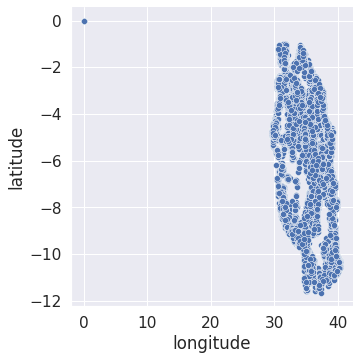

In [193]:
sns.relplot(
    x="longitude", y="latitude", data=df_train
);

In [194]:
#bar chart fucntion
def bar_chart_stacked(df_train,feature,stacked=True):
    functional = df_train[df_train["status_group"]==0][feature].value_counts()
    repair = df_train[df_train["status_group"]==1][feature].value_counts()
    non_functional = df_train[df_train["status_group"]==2][feature].value_counts()
    status_group_df = pd.DataFrame([functional,non_functional,repair])
    status_group_df.index = ['Functional','Repair','Non_Functional']
    ax = status_group_df.plot(kind='bar',stacked=stacked, figsize=(5,5))

In [195]:
#bar chart compare function
def bar_chart_compare(df_train, feature1, feature2=None, title = "Title"):
    plt.figure(figsize = [30,10])
    plt.title(title)
    g = sns.barplot(x=feature1, y='status_group', hue=feature2, ci=None, data=df_train).set_ylabel('Rate')

In [196]:
#distributoion of a column function
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(df_train[feature], color='g', bins=bins, ax=ax)

In [197]:
#density function
def plot_kernel_density_estimate(df_train, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(df_train[feature1].loc[df_train["status_group"] == 0],
                shade= True, ax=ax, label='Functional').set_xlabel(feature1)
    sns.kdeplot(df_train[feature1].loc[df_train["status_group"] == 1],
                shade=True, ax=ax, label="Repair")
    sns.kdeplot(df_train[feature1].loc[df_train["status_group"] == 2],
                shade=True, ax=ax, label="Non Functional")

In [198]:
#column vs status_group plot function
def plot_quartiles(df_train, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(15,10))
    fare_ranges = pd.qcut(df_train[feature], len(categories), labels = categories)
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=df_train.status_group, ci=None, ax=axarr).set_ylabel('Rate')

In [199]:
#view categories in a column function
def show_countplot(df_train, feature, title, fsize = (30,10)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(df_train[feature], ax=ax).set_title(title)

In [200]:
#compare catogories in a column with survival function
def show_compare_countplot(df_train, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(30,10))
    p = sns.countplot(x = feature1, hue = feature2, data = df_train, ax=ax).set_title(title)

In [201]:
label = LabelEncoder()
df_train['status_group'] = label.fit_transform(df_train['status_group'])
df_train['status_group'].value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
Name: status_group, dtype: float64

In [202]:
target = df_train["status_group"].value_counts()
target

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

*   functional                 0
*   functional needs repair    1
*   non functional             2




#### source

In [203]:
#value count for source_class
df_train["source"].value_counts().to_frame()

source
spring                 17021
shallow well           16824
machine dbh            11075
river                   9612
rainwater harvesting    2295
hand dtw                 874
lake                     765
dam                      656
other                    212
unknown                   66

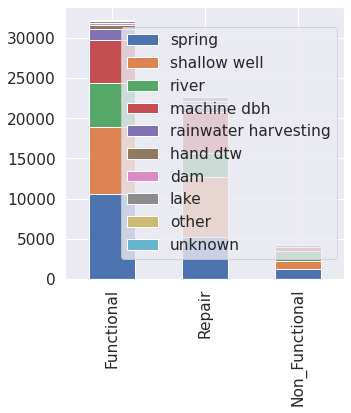

In [204]:
#bar chart for source_class
bar_chart_stacked(df_train, "source")

In [205]:
#funtional by source
df_train.groupby('source').status_group.mean()

source
dam                     1.192073
hand dtw                0.843249
lake                    1.560784
machine dbh             0.976524
other                   0.806604
rainwater harvesting    0.655338
river                   0.735851
shallow well            0.953578
spring                  0.680454
unknown                 0.969697
Name: status_group, dtype: float64

#### source_class

In [206]:
#value count for source_class
df_train["source_class"].value_counts().to_frame()

source_class
groundwater         45794
surface             13328
unknown               278

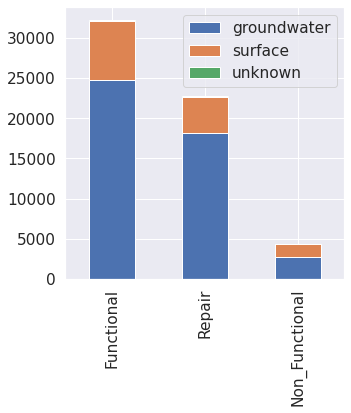

In [207]:
#bar chart for source_class
bar_chart_stacked(df_train, "source_class")

**Most of the ground water methods are funtional (some needs repair).**

In [208]:
#funtional by source_class
df_train.groupby('source_class').status_group.mean()

source_class
groundwater    0.855505
surface        0.791792
unknown        0.845324
Name: status_group, dtype: float64

#### source_type 

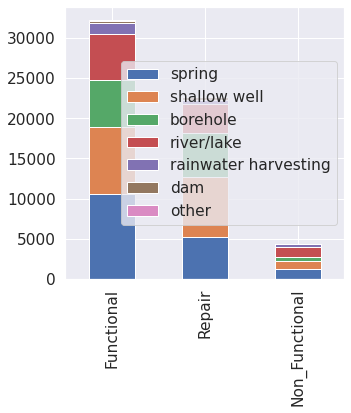

In [209]:
#bar chart for Pclass
bar_chart_stacked(df_train, "source_type")

In [210]:
#class distribution
pd.pivot_table(df_train, index = 'status_group', columns = 'source_type', values = 'source_class' ,aggfunc ='count')

source_type   borehole  dam  other  rainwater harvesting  river/lake  \
status_group                                                           
0                 5919  253    158                  1386        5627   
1                  508   24      5                   314        1233   
2                 5522  379    115                   595        3517   

source_type   shallow well  spring  
status_group                        
0                     8324   10592  
1                      957    1276  
2                     7543    5153

In [211]:
#survival by class
df_train.groupby(['source_type']).status_group.mean().to_frame()

status_group
source_type                       
borehole                  0.966775
dam                       1.192073
other                     0.845324
rainwater harvesting      0.655338
river/lake                0.796666
shallow well              0.953578
spring                    0.680454

In [212]:
#compare pClass, sex, survival
bar_chart_compare(df_train, "source_class", "source_type")

In [213]:
#distribution of Pclass vs sex
df_train.groupby(['source_class', "source_type"]).status_group.mean().to_frame()

status_group
source_class source_type                       
groundwater  borehole                  0.966775
             shallow well              0.953578
             spring                    0.680454
surface      dam                       1.192073
             rainwater harvesting      0.655338
             river/lake                0.796666
unknown      other                     0.845324

#### gps_height

In [214]:
#gps_height distribution
plot_distribution(df_train, "gps_height", "Altitude Distribution")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


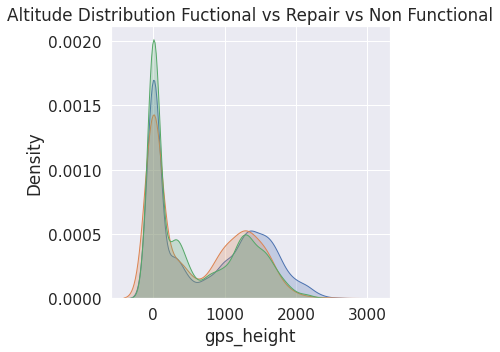

In [215]:
#gps_height density
plot_kernel_density_estimate(df_train, "gps_height", "Altitude Distribution Fuctional vs Repair vs Non Functional")

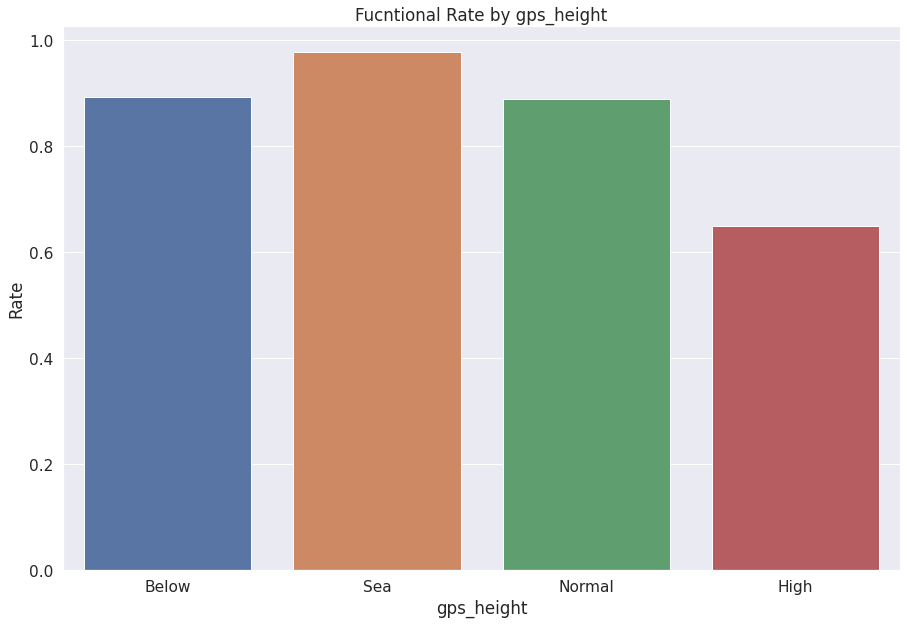

In [216]:
#categorize age groups based on age
categories = ['Below', 'Sea', 'Normal', 'High']
plot_quartiles(df_train, "gps_height", "Fucntional Rate by gps_height", categories)

#### permit

In [217]:
df_train.permit.describe()

count     56344
unique        2
top        True
freq      38852
Name: permit, dtype: object

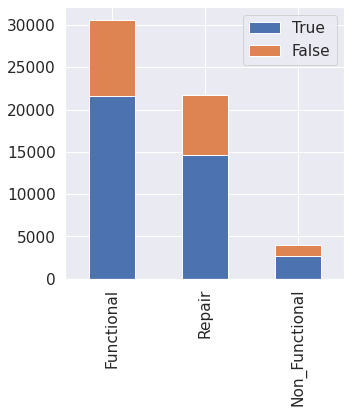

In [218]:
bar_chart_stacked(df_train, "permit")

Most of the non functional points are permited ones

#### recorded_by

In [219]:
df_train.recorded_by.describe()

count                       59400
unique                          1
top       GeoData Consultants Ltd
freq                        59400
Name: recorded_by, dtype: object

In [220]:
bar_chart_stacked(df_train, "recorded_by")

All data are provided by GeoData Consultants Ltd

#### public_meeting 

In [221]:
df_train.public_meeting.describe()

count     56066
unique        2
top        True
freq      51011
Name: public_meeting, dtype: object

In [222]:
bar_chart_stacked(df_train, "public_meeting")

#### scheme_management

In [223]:
df_train.scheme_management.describe()

count     55523
unique       12
top         VWC
freq      36793
Name: scheme_management, dtype: object

In [224]:
bar_chart_stacked(df_train, "scheme_management")

Most of the schemes are managed by SWC

#### scheme_name

In [225]:
df_train.scheme_name.describe()

count     31234
unique     2696
top           K
freq        682
Name: scheme_name, dtype: object

In [226]:
#class distribution
pd.pivot_table(df_train, index = 'status_group', columns = 'scheme_management', values = 'scheme_name' ,aggfunc ='count')

scheme_management  Company  None  Other  Parastatal  Private operator  SWC  \
status_group                                                                 
0                    513.0   0.0  100.0       319.0             220.0  0.0   
1                     33.0   NaN   12.0        60.0               5.0  0.0   
2                    479.0   NaN  116.0       151.0             126.0  0.0   

scheme_management  Trust      VWC     WUA    WUG  Water Board  Water authority  
status_group                                                                    
0                    6.0  11124.0  1656.0  630.0       1919.0           1180.0  
1                    3.0   1394.0   176.0  176.0         75.0            371.0  
2                   10.0   8026.0   534.0  340.0        507.0            667.0

In [227]:
pd.pivot_table(df_train, index = 'status_group', columns = 'scheme_name', values = 'scheme_management' ,aggfunc ='count')

scheme_name   14 Kambarage     A  ADP  ADP Simbo  ADP Simbu  ADRA  AIC  \
status_group                                                             
0                      7.0  23.0  6.0       15.0        NaN   7.0  1.0   
1                      NaN   2.0  NaN        NaN        NaN   NaN  NaN   
2                      NaN  17.0  3.0       10.0        1.0   1.0  NaN   

scheme_name   AIC kahunda  AMREF  AMRSF  AUWASA Pipe scheme  \
status_group                                                  
0                     1.0    NaN    NaN                 4.0   
1                     NaN    NaN    NaN                 NaN   
2                     NaN    3.0    1.0                 NaN   

scheme_name   AUWASA pipe scheme  Adra  African Barrick Gold  \
status_group                                                   
0                            6.0   0.0                   1.0   
1                            NaN   NaN                   NaN   
2                            NaN   NaN                   NaN   

scheme_name   Akheri gravity water supply  Alpha crust  Amani Water Supply  \
status_group                                                                 
0                                     5.0          1.0                 NaN   
1                                     2.0          1.0                11.0   
2                                     2.0          NaN                 NaN   

scheme_name   Amani spring  Anglic  Araa  Arashi water scheme  Arisi/himo  \
status_group                                                                
0                     23.0    22.0   NaN                  1.0         1.0   
1                      NaN     NaN   NaN                  NaN         2.0   
2                      2.0     2.0   2.0                  NaN         NaN   

scheme_name   Arusha chini water supply  Atta     B  BADIMKA  \
status_group                                                   
0                                   1.0   5.0   7.0      3.0   
1                                   NaN   NaN   NaN      NaN   
2                                   3.0   NaN  14.0      NaN   

scheme_name   BASSONYAGWE AND NG'WANDKW  BFFS  BFFS water supplying  \
status_group                                                          
0                                  14.0   2.0                   NaN   
1                                   NaN   NaN                   NaN   
2                                   3.0   6.0                   1.0   

scheme_name   BL Bingati A  BL Bingati B  BL Bondeni  BL Bonifas Kingu  \
status_group                                                             
0                      3.0           1.0         2.0               1.0   
1                      NaN           NaN         NaN               NaN   
2                      NaN           NaN         NaN               NaN   

scheme_name   BL Cosmas Woiso  BL Dahani Sec  BL Dispensary  BL Eligudi  \
status_group                                                              
0                         1.0            4.0            1.0         NaN   
1                         NaN            NaN            NaN         NaN   
2                         NaN            NaN            NaN         1.0   

scheme_name   BL Embokoi  BL Embukoi  BL Erasto Laizer  BL Esilalei  \
status_group                                                          
0                    1.0         2.0               1.0          1.0   
1                    NaN         NaN               NaN          NaN   
2                    NaN         NaN               NaN          NaN   

scheme_name   BL K puchini Sisters  BL Kalimaji  BL Kandash  BL Kandashi  \
status_group                                                               
0                              1.0          4.0         2.0          1.0   
1                              NaN          NaN         NaN          NaN   
2                              NaN          NaN         NaN          NaN   

scheme_name   BL Kashashi  BL Kashofu  BL Kiboshoni  B

#### basin

In [228]:
df_train.basin.describe()

count             59400
unique                9
top       Lake Victoria
freq              10248
Name: basin, dtype: object

In [229]:
bar_chart_stacked(df_train, "basin")

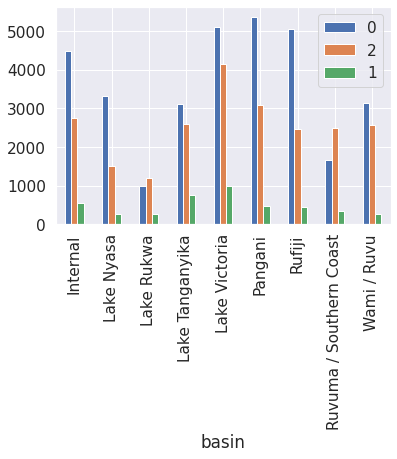

In [230]:
df_train[['basin']].join(pd.get_dummies(df_train['status_group'])).groupby('basin')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

#### water_quality 

In [231]:
df_train["water_quality"].value_counts().to_frame()

water_quality
soft                        50818
salty                        4856
unknown                      1876
milky                         804
coloured                      490
salty abandoned               339
fluoride                      200
fluoride abandoned             17

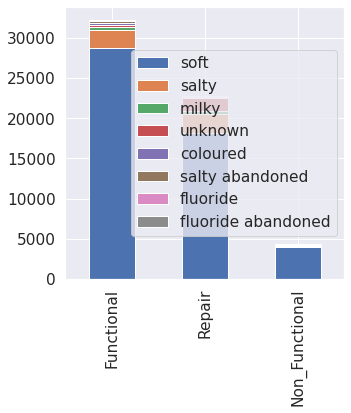

In [232]:
bar_chart_stacked(df_train, "water_quality")

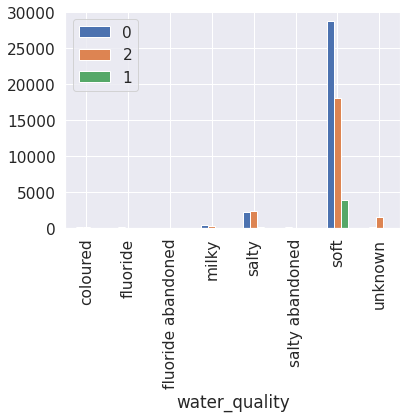

In [233]:
df_train[['water_quality']].join(pd.get_dummies(df_train['status_group'])).groupby('water_quality')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

In [234]:
water = df_train[['water_quality']].join(pd.get_dummies(df_train['status_group'])).groupby('water_quality')[df_train['status_group'].unique()].apply(sum)
water.drop('soft', axis=0, inplace=True)
water

0     2    1
water_quality                      
coloured             246   190   54
fluoride             151    36   13
fluoride abandoned     6    11    0
milky                438   352   14
salty               2220  2411  225
salty abandoned      174    93   72
unknown              264  1577   35

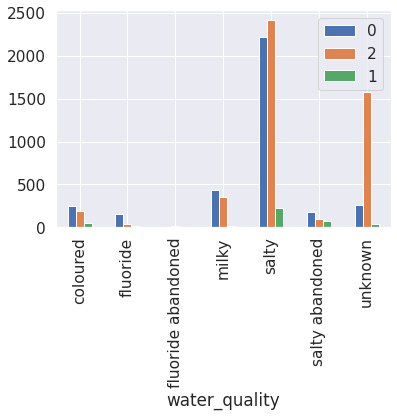

In [235]:
water.plot(kind='bar')
plt.show()

#### quality_group 

In [236]:
df_train["quality_group"].value_counts().to_frame()

quality_group
good              50818
salty              5195
unknown            1876
milky               804
colored             490
fluoride            217

In [237]:
bar_chart_stacked(df_train, "quality_group")

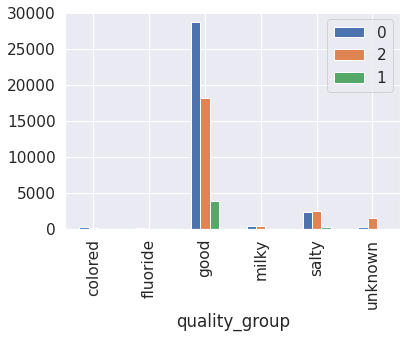

In [238]:
df_train[['quality_group']].join(pd.get_dummies(df_train['status_group'])).groupby('quality_group')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

In [239]:
quality = df_train[['quality_group']].join(pd.get_dummies(df_train['status_group'])).groupby('quality_group')[df_train['status_group'].unique()].apply(sum)
quality.drop('good', axis=0, inplace=True)
quality

0     2    1
quality_group                 
colored         246   190   54
fluoride        157    47   13
milky           438   352   14
salty          2394  2504  297
unknown         264  1577   35

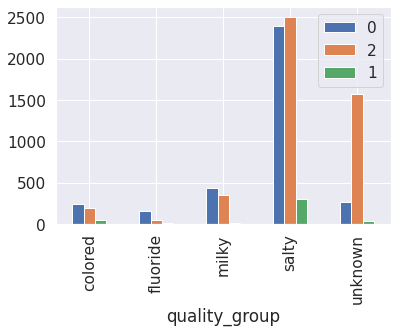

In [240]:
quality.plot(kind='bar')
plt.show()

In [241]:
#class distribution
pd.pivot_table(df_train, index = 'status_group', columns = 'water_quality', values = 'quality_group' ,aggfunc ='count')

water_quality  coloured  fluoride  fluoride abandoned  milky   salty  \
status_group                                                           
0                 246.0     151.0                 6.0  438.0  2220.0   
1                  54.0      13.0                 NaN   14.0   225.0   
2                 190.0      36.0                11.0  352.0  2411.0   

water_quality  salty abandoned     soft  unknown  
status_group                                      
0                        174.0  28760.0    264.0  
1                         72.0   3904.0     35.0  
2                         93.0  18154.0   1577.0

In [242]:
bar_chart_compare(df_train, "water_quality", "quality_group")

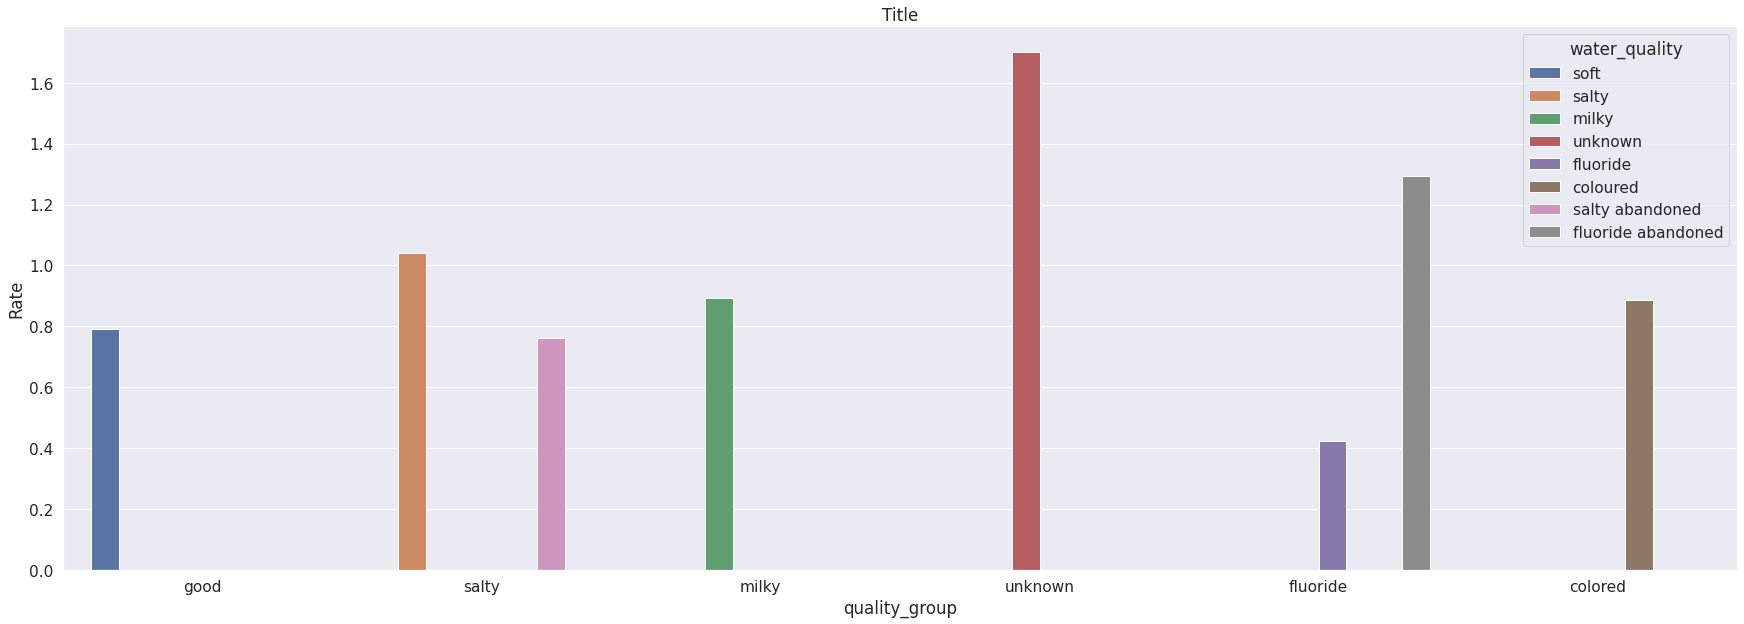

In [243]:
bar_chart_compare(df_train,"quality_group","water_quality")

#### quantity

In [244]:
df_train["quantity"].value_counts().to_frame()

quantity
enough           33186
insufficient     15129
dry               6246
seasonal          4050
unknown            789

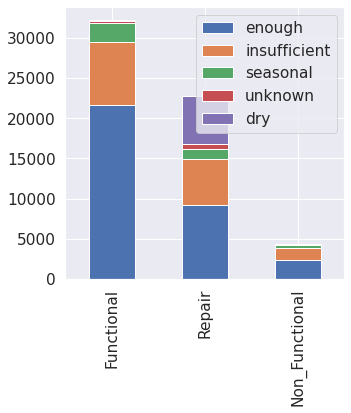

In [245]:
bar_chart_stacked(df_train, "quantity")

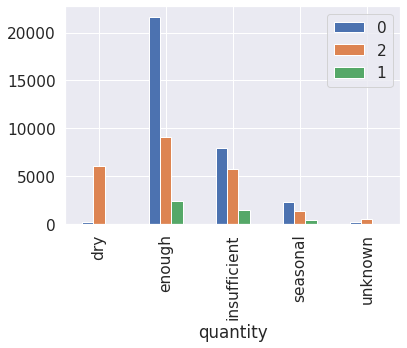

In [246]:
df_train[['quantity']].join(pd.get_dummies(df_train['status_group'])).groupby('quantity')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

#### quantity_group 

In [247]:
df_train["quantity_group"].value_counts().to_frame()

quantity_group
enough                 33186
insufficient           15129
dry                     6246
seasonal                4050
unknown                  789

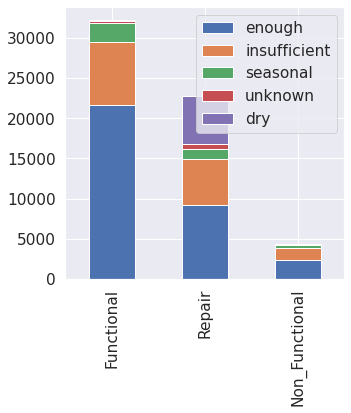

In [248]:
bar_chart_stacked(df_train, "quantity_group")

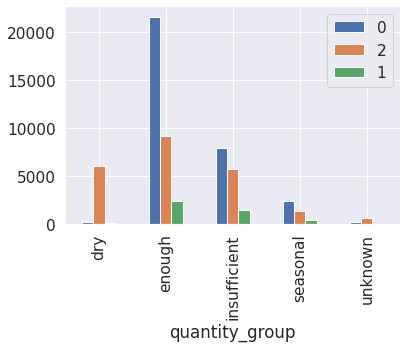

In [249]:
df_train[['quantity_group']].join(pd.get_dummies(df_train['status_group'])).groupby('quantity_group')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

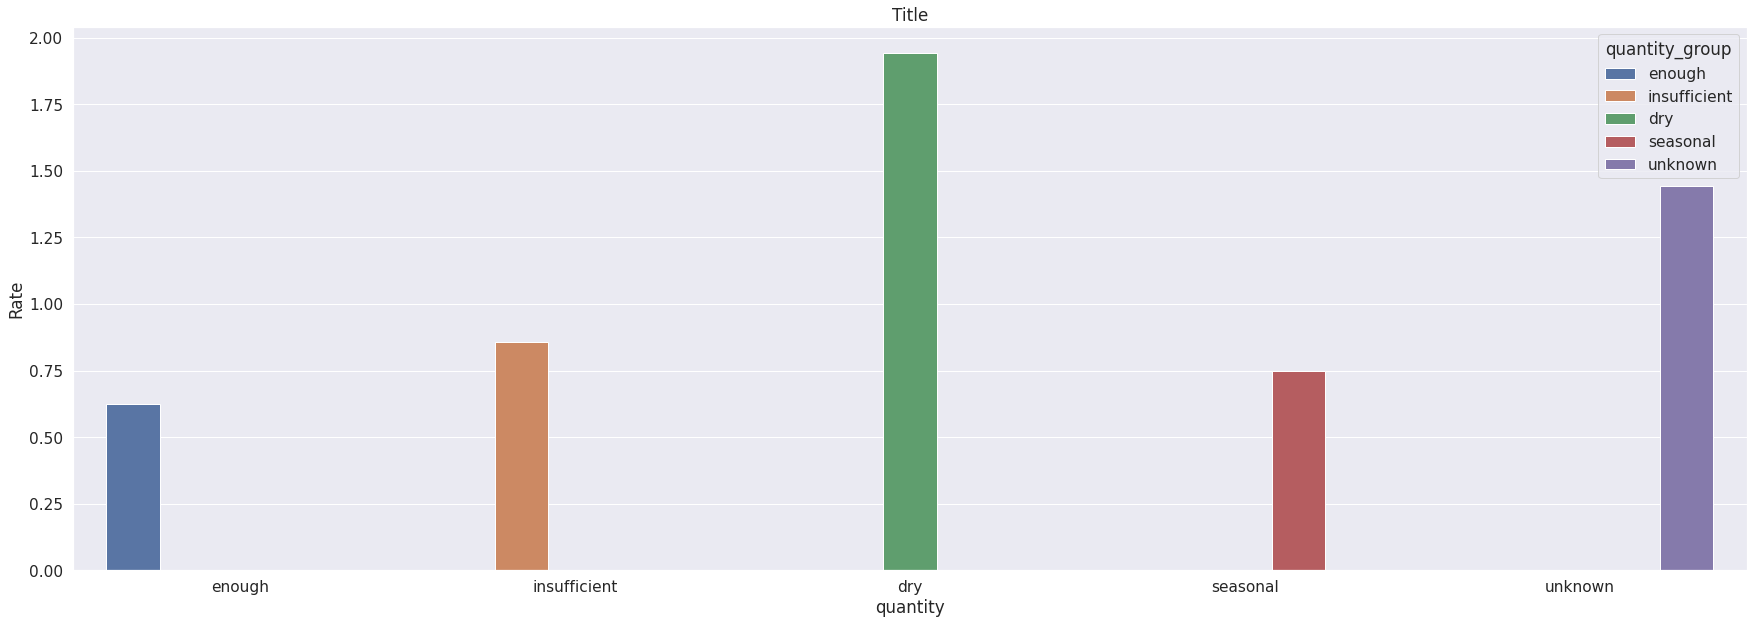

In [250]:
bar_chart_compare(df_train,"quantity","quantity_group")

#### waterpoint_type 

In [251]:
df_train["waterpoint_type"].value_counts().to_frame()

waterpoint_type
communal standpipe                     28522
hand pump                              17488
other                                   6380
communal standpipe multiple             6103
improved spring                          784
cattle trough                            116
dam                                        7

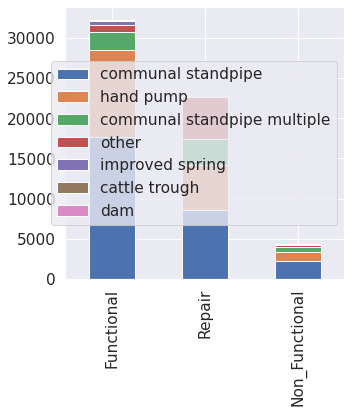

In [252]:
bar_chart_stacked(df_train, "waterpoint_type")

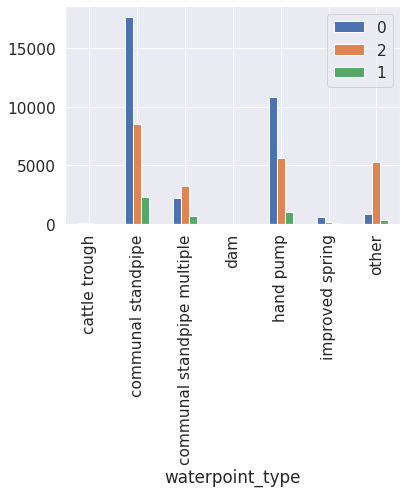

In [253]:
df_train[['waterpoint_type']].join(pd.get_dummies(df_train['status_group'])).groupby('waterpoint_type')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

#### waterpoint_type_group 

In [254]:
df_train["waterpoint_type_group"].value_counts().to_frame()

waterpoint_type_group
communal standpipe                  34625
hand pump                           17488
other                                6380
improved spring                       784
cattle trough                         116
dam                                     7

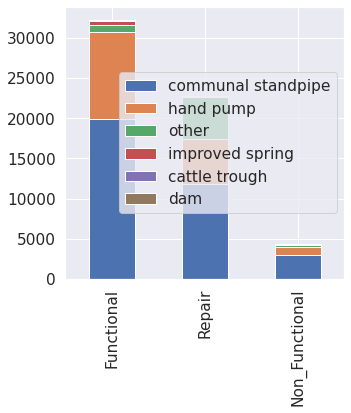

In [255]:
bar_chart_stacked(df_train, "waterpoint_type_group")

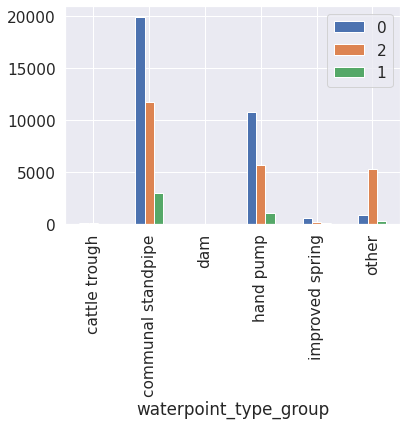

In [256]:
df_train[['waterpoint_type_group']].join(pd.get_dummies(df_train['status_group'])).groupby('waterpoint_type_group')[df_train['status_group'].unique()].apply(sum).plot(kind='bar')
plt.show()

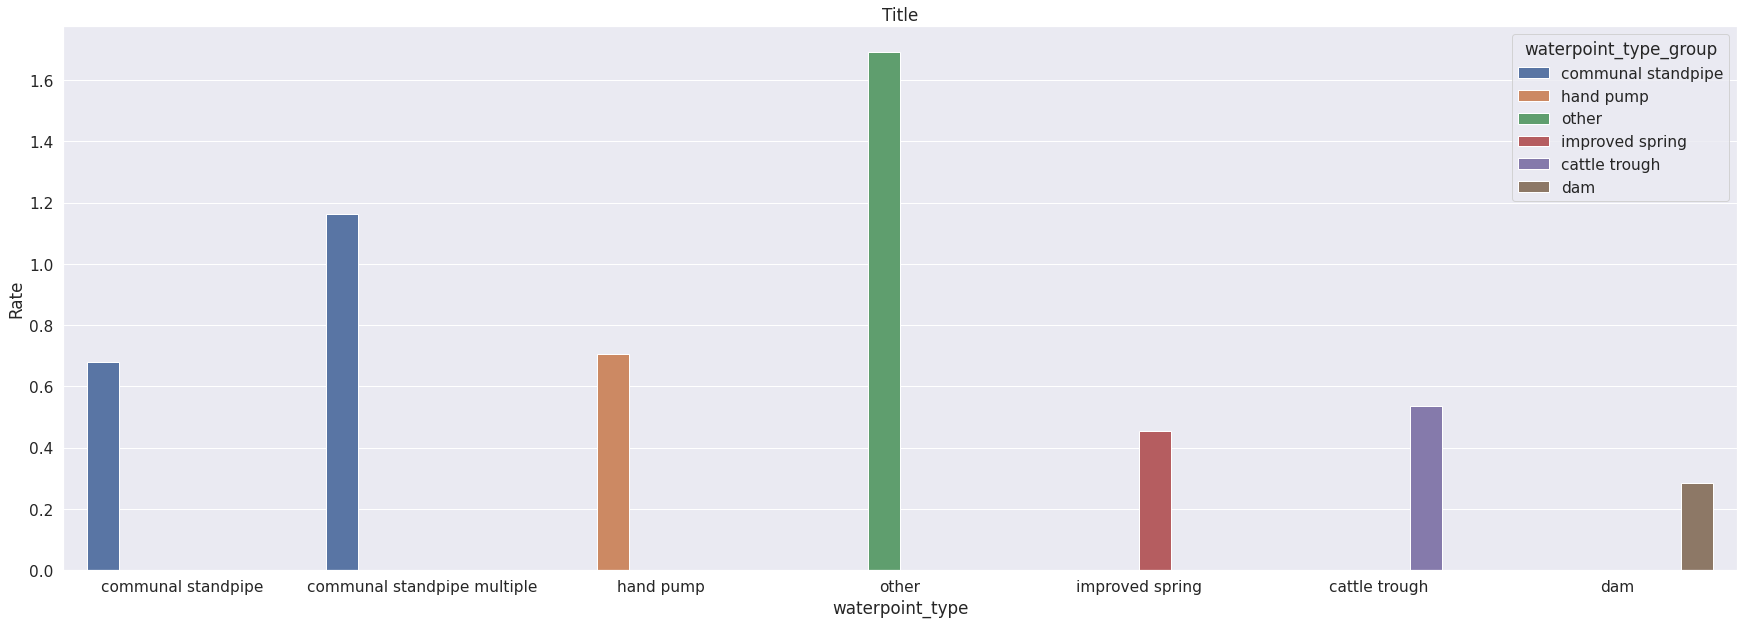

In [257]:
bar_chart_compare(df_train,"waterpoint_type","waterpoint_type_group")

#### payment

In [258]:
df_train["payment"].value_counts().to_frame()

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


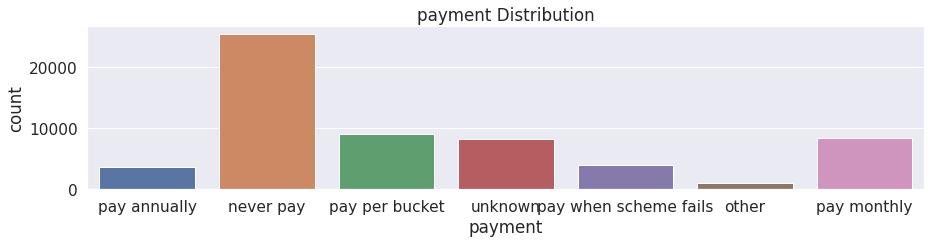

In [259]:
show_countplot(df_train, "payment", 'payment Distribution', (15,3))

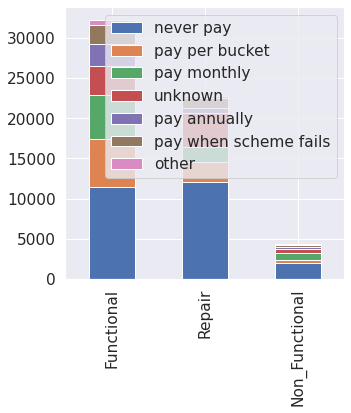

In [260]:
bar_chart_stacked(df_train, "payment")

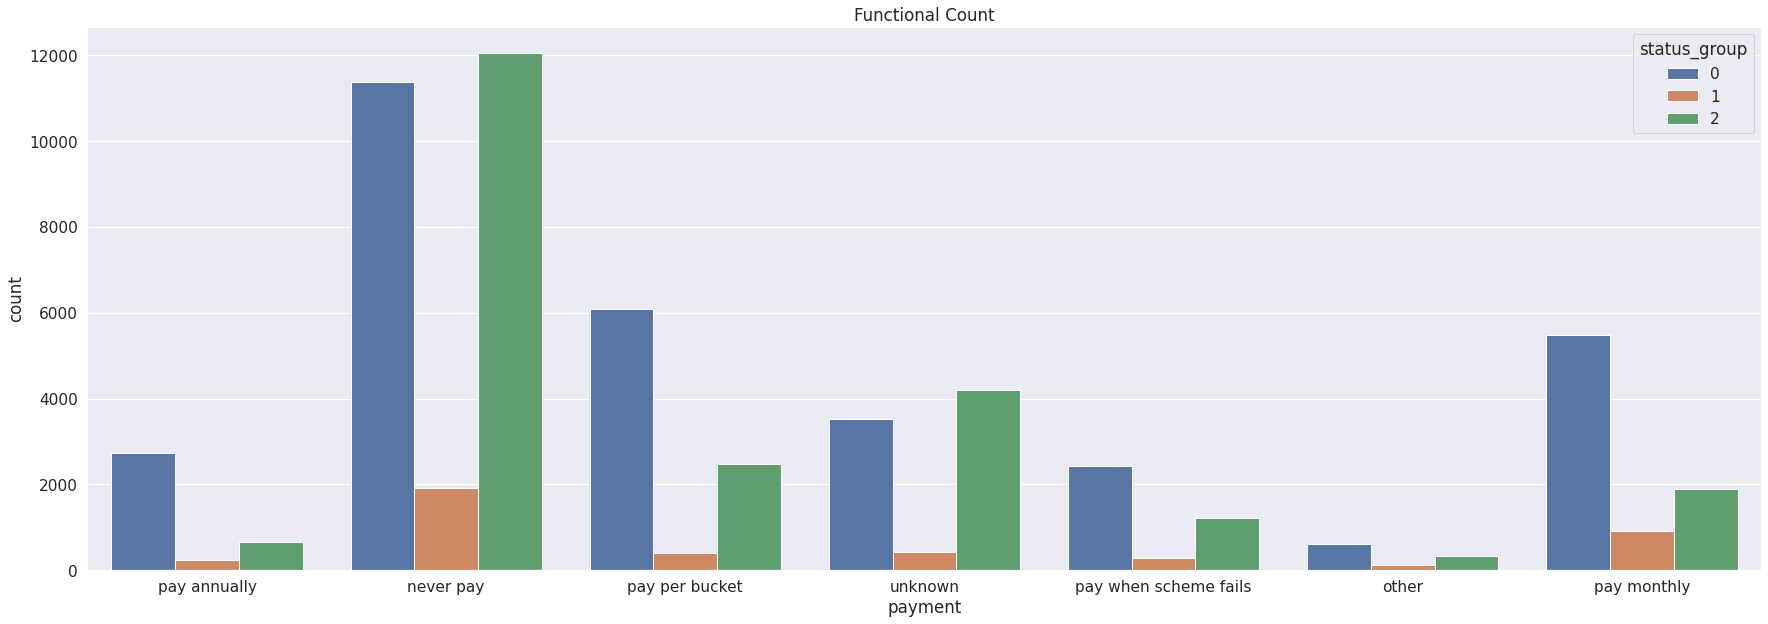

In [261]:
show_compare_countplot(df_train, "payment","status_group", "Functional Count")

#### payment_type 

In [262]:
df_train["payment_type"].value_counts().to_frame()

payment_type
never pay          25348
per bucket          8985
monthly             8300
unknown             8157
on failure          3914
annually            3642
other               1054

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


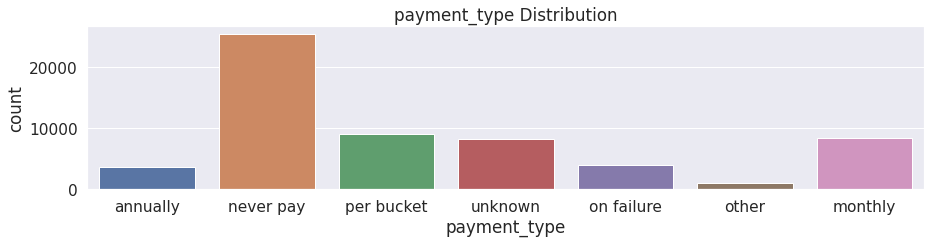

In [263]:
show_countplot(df_train, "payment_type", 'payment_type Distribution', (15,3))

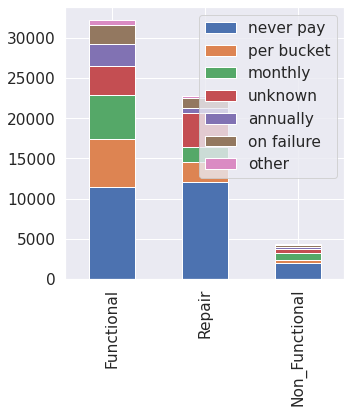

In [264]:
bar_chart_stacked(df_train, "payment_type")

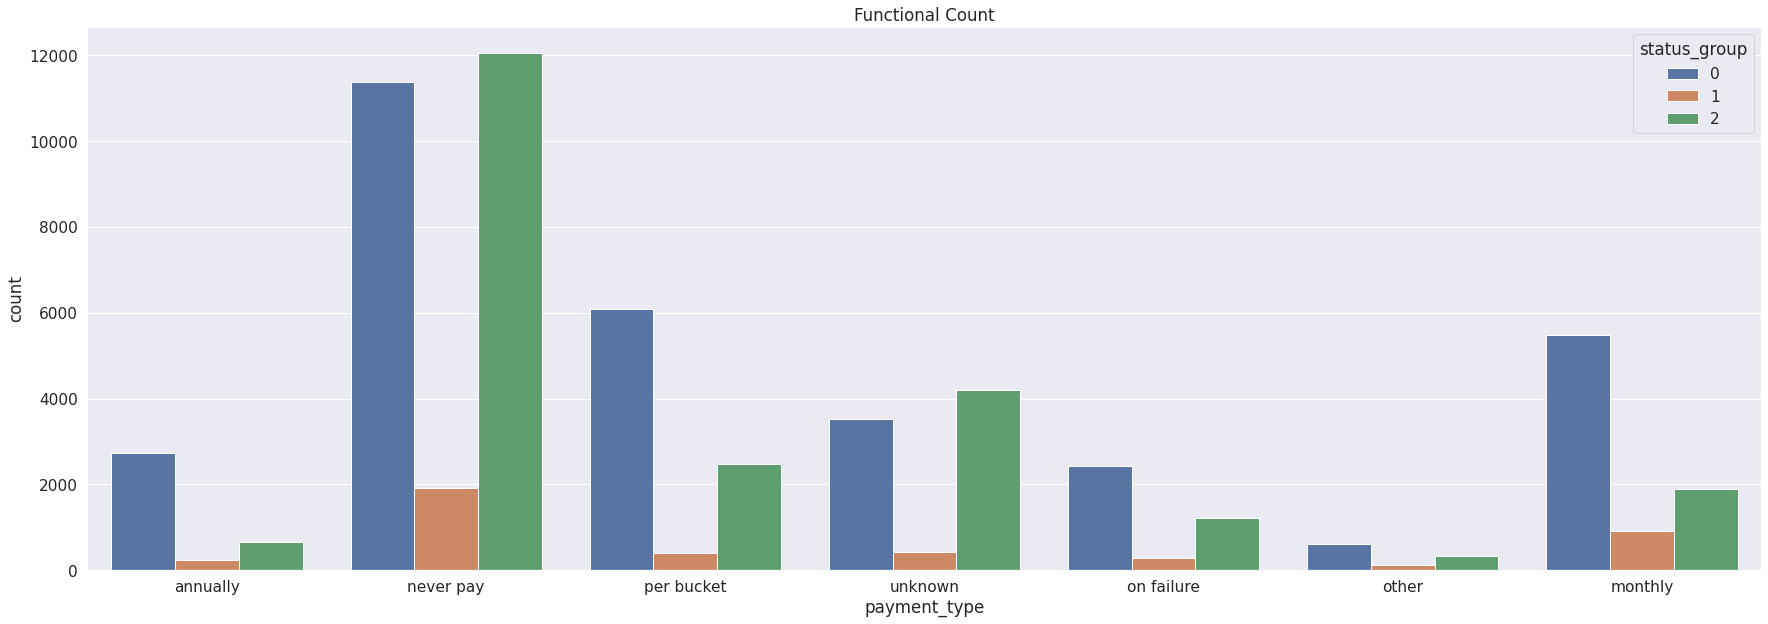

In [265]:
show_compare_countplot(df_train, "payment_type","status_group", "Functional Count")

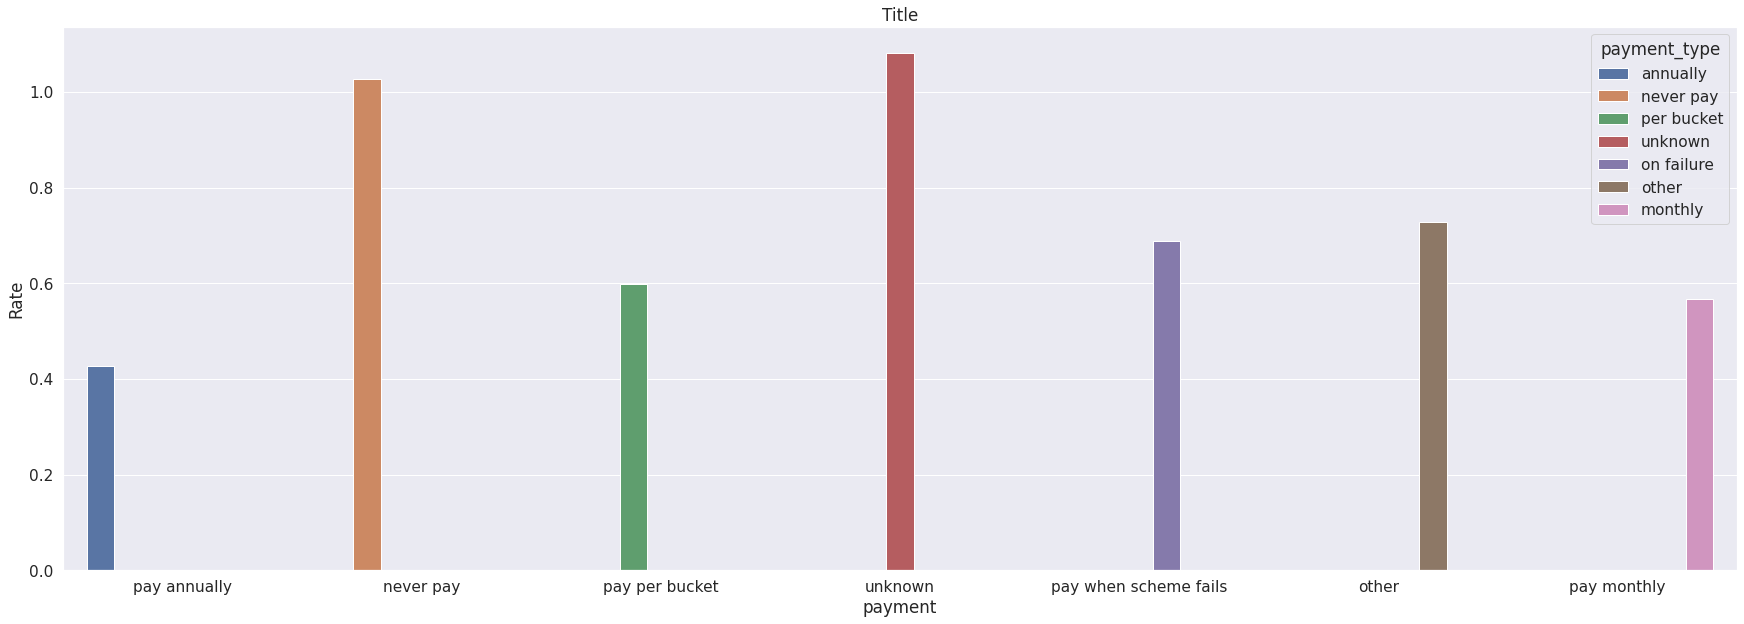

In [266]:
bar_chart_compare(df_train,"payment","payment_type")

#### extraction_type 

In [267]:
df_train["extraction_type"].value_counts().to_frame()

extraction_type
gravity                              26780
nira/tanira                           8154
other                                 6430
submersible                           4764
swn 80                                3670
mono                                  2865
india mark ii                         2400
afridev                               1770
ksb                                   1415
other - rope pump                      451
other - swn 81                         229
windmill                               117
india mark iii                          98
cemo                                    90
other - play pump                       85
walimi                                  48
climax                                  32
other - mkulima/shinyanga                2

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


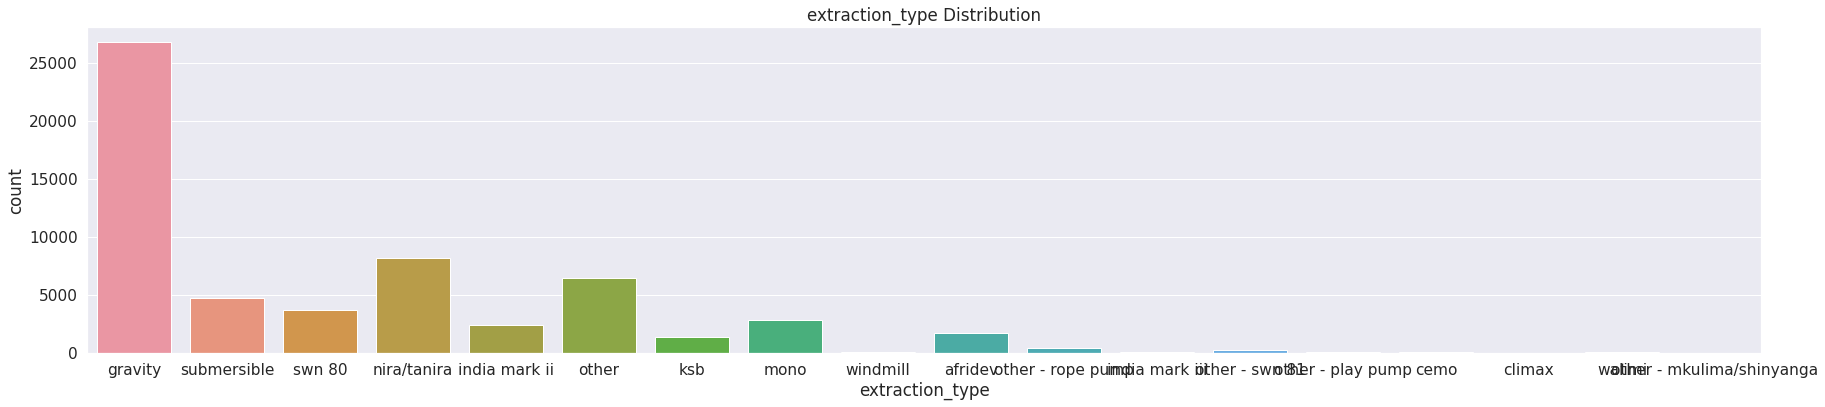

In [268]:
show_countplot(df_train, "extraction_type", 'extraction_type Distribution', (30,6))

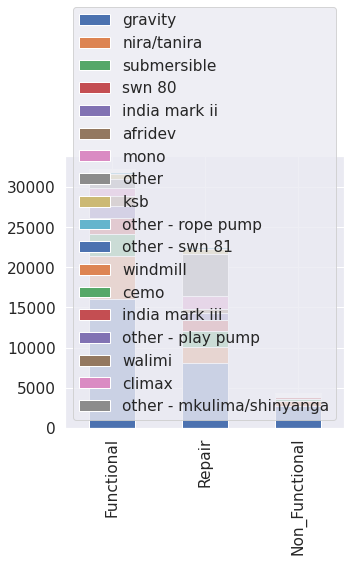

In [269]:
bar_chart_stacked(df_train, "extraction_type")

#### extraction_type_group 

In [270]:
df_train["extraction_type_group"].value_counts().to_frame()

extraction_type_group
gravity                          26780
nira/tanira                       8154
other                             6430
submersible                       6179
swn 80                            3670
mono                              2865
india mark ii                     2400
afridev                           1770
rope pump                          451
other handpump                     364
other motorpump                    122
wind-powered                       117
india mark iii                      98

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


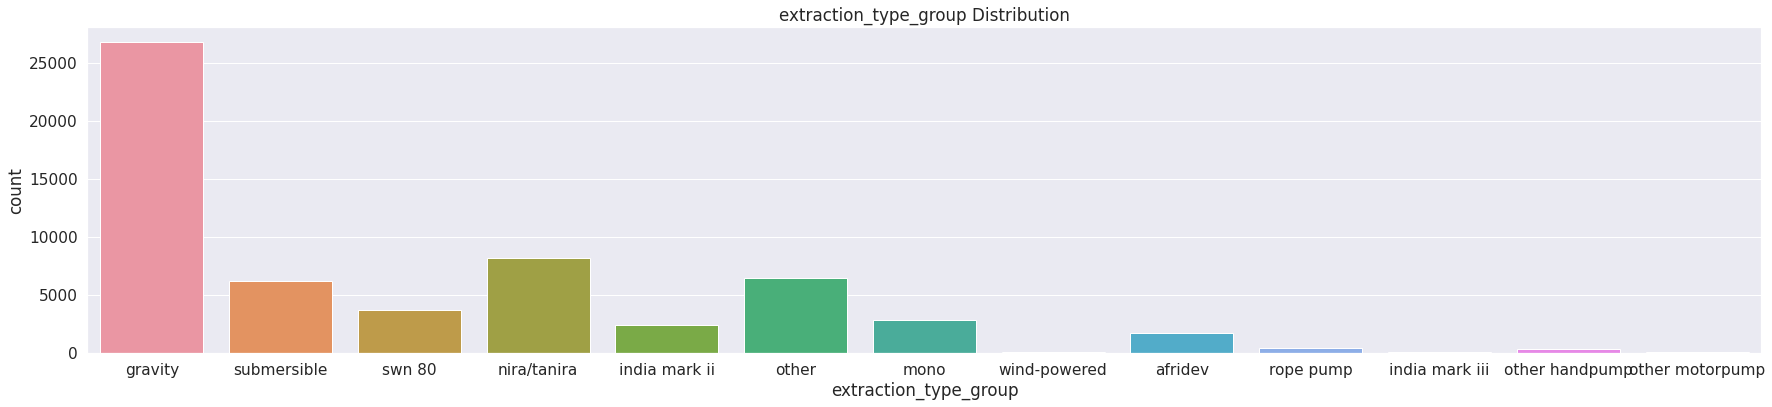

In [271]:
show_countplot(df_train, "extraction_type_group", 'extraction_type_group Distribution', (30,6))

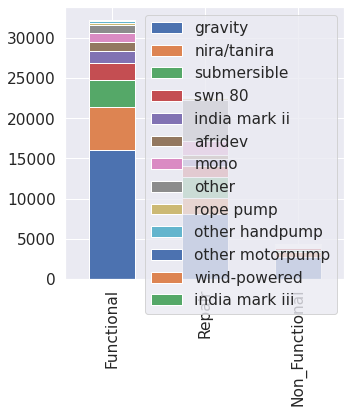

In [272]:
bar_chart_stacked(df_train, "extraction_type_group")

In [273]:
show_compare_countplot(df_train, "extraction_type","extraction_type_group", "Functional Count")

#### extraction_type_class 

In [274]:
df_train["extraction_type_class"].value_counts().to_frame()

extraction_type_class
gravity                       26780
handpump                      16456
other                          6430
submersible                    6179
motorpump                      2987
rope pump                       451
wind-powered                    117

In [275]:
show_countplot(df_train, "extraction_type_class", 'extraction_type_class Distribution', (30,6))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [276]:
bar_chart_stacked(df_train, "extraction_type_class")

In [277]:
show_compare_countplot(df_train, "extraction_type_class","status_group", "Functional Count")

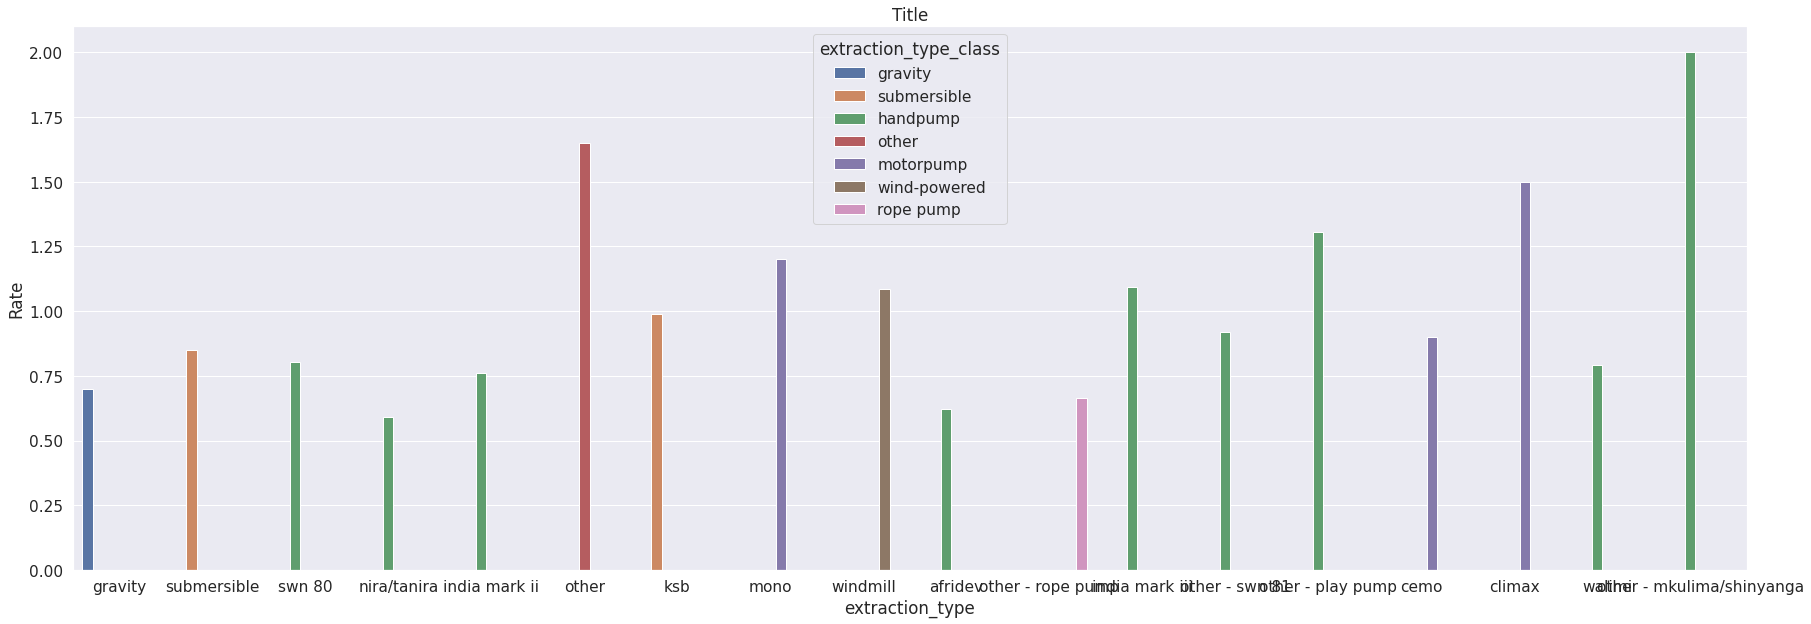

In [278]:
bar_chart_compare(df_train,"extraction_type","extraction_type_class")

In [279]:
bar_chart_compare(df_train,"extraction_type_group","extraction_type_class")

#### Contruction Year

In [280]:
df_train["construction_year"].value_counts().to_frame()

construction_year
0                 20709
2010               2645
2008               2613
2009               2533
2000               2091
2007               1587
2006               1471
2003               1286
2011               1256
2004               1123
2012               1084
2002               1075
1978               1037
1995               1014
2005               1011
1999                979
1998                966
1990                954
1985                945
1980                811
1996                811
1984                779
1982                744
1994                738
1972                708
1974                676
1997                644
1992                640
1993                608
2001                540
1988                521
1983                488
1975                437
1986                434
1976                414
1970                411
1991                324
1989                316
1987                302
1981                238
1977                202
1979                192
1973                184
2013                176
1971                145
1960                102
1967                 88
1963                 85
1968                 77
1969                 59
1964                 40
1962                 30
1961                 21
1965                 19
1966                 17

In [281]:
df_train[['construction_year']].join(pd.get_dummies(df_train['status_group'])).groupby('construction_year')[df_train['status_group'].unique()].apply(sum)

0     2     1
construction_year                   
0                  10555  8365  1789
1960                  24    72     6
1961                   2    16     3
1962                   7    22     1
1963                  31    48     6
1964                   7    32     1
1965                  11     7     1
1966                   6    11     0
1967                  31    40    17
1968                  22    51     4
1969                  15    41     3
1970                  99   297    15
1971                  82    57     6
1972                 178   462    68
1973                  55   121     8
1974                 234   403    39
1975                 144   252    41
1976                  85   277    52
1977                  62   130    10
1978                 426   514    97
1979                  41   139    12
1980                 258   493    60
1981                  85   142    11
1982                 236   454    54
1983                 187   280    21
1984                 365   348    66
1985                 324   537    84
1986                 212   188    34
1987                 143   122    37
1988                 245   234    42
1989                 165   137    14
1990                 466   429    59
1991                 141   166    17
1992                 361   238    41
1993                 285   289    34
1994                 380   315    43
1995                 593   346    75
1996                 386   377    48
1997                 291   286    67
1998                 542   337    87
1999                 694   238    47
2000                1279   676   136
2001                 331   172    37
2002                 692   325    58
2003                 828   387    71
2004                 704   349    70
2005                 578   344    89
2006                 883   453   135
2007                1081   390   116
2008                1839   647   127
2009                1774   621   138
2010                2023   532    90
2011                 943   235    78
2012                 726   307    51
2013                 102    73     1

#### district_code

In [282]:
df_train["district_code"].value_counts().to_frame()

district_code
1           12203
2           11173
3            9998
4            8999
5            4356
6            4074
7            3343
8            1043
30            995
33            874
53            745
43            505
13            391
23            293
63            195
62            109
60             63
0              23
80             12
67              6

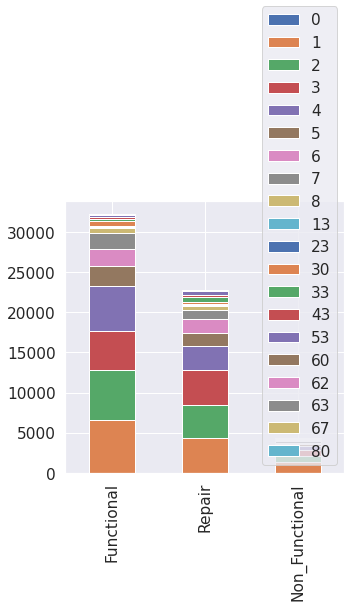

In [283]:
bar_chart_stacked(df_train, "district_code")

#### region

In [284]:
df_train["region"].value_counts().to_frame()

region
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805

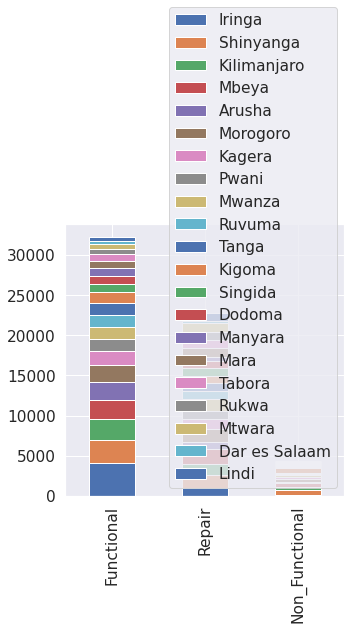

In [285]:
bar_chart_stacked(df_train, "region")

#### region_code

In [286]:
df_train["region_code"].value_counts().to_frame()

region_code
11         5300
17         5011
12         4639
3          4379
5          4040
18         3324
19         3047
2          3024
16         2816
10         2640
4          2513
1          2201
13         2093
14         1979
20         1969
15         1808
6          1609
21         1583
80         1238
60         1025
90          917
7           805
99          423
9           390
24          326
8           300
40            1

In [287]:
bar_chart_stacked(df_train, "region_code")

In [288]:
bar_chart_compare(df_train,"region","region_code")

#### subvillage

In [289]:
df_train["subvillage"].value_counts().to_frame()

subvillage
Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
...                ...
Mmumu                1
Samunge              1
Iyang                1
Kilongola            1
Nyabisindu           1

[19287 rows x 1 columns]

In [290]:
sub_vil = df_train.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
sub_vil

region_code
1                    Kawawa
2                  Madukani
3                   Majengo
4                    Sokoni
5                   Shuleni
6                    Vikuge
7      Mtaa Wa Kitunda Kati
8     [Madukani, Mapinduzi]
9                    Madina
10                 Muungano
11                        M
12                  Katumba
13                 Madukani
14                  Majengo
15                  Majengo
16                  Majengo
17                 Madukani
18              Bunukangoma
19                        1
20                    Senta
21                 Madukani
24                     Kati
40             Kimbangulile
60                 Mwandege
80                  Shuleni
90                  Majengo
99                   Sokoni
Name: subvillage, dtype: object

#### scheme_management

In [291]:
df_train["scheme_management"].value_counts().to_frame()

scheme_management
VWC                           36793
WUG                            5206
Water authority                3153
WUA                            2883
Water Board                    2748
Parastatal                     1680
Private operator               1063
Company                        1061
Other                           766
SWC                              97
Trust                            72
None                              1

In [292]:
bar_chart_stacked(df_train, "scheme_management")

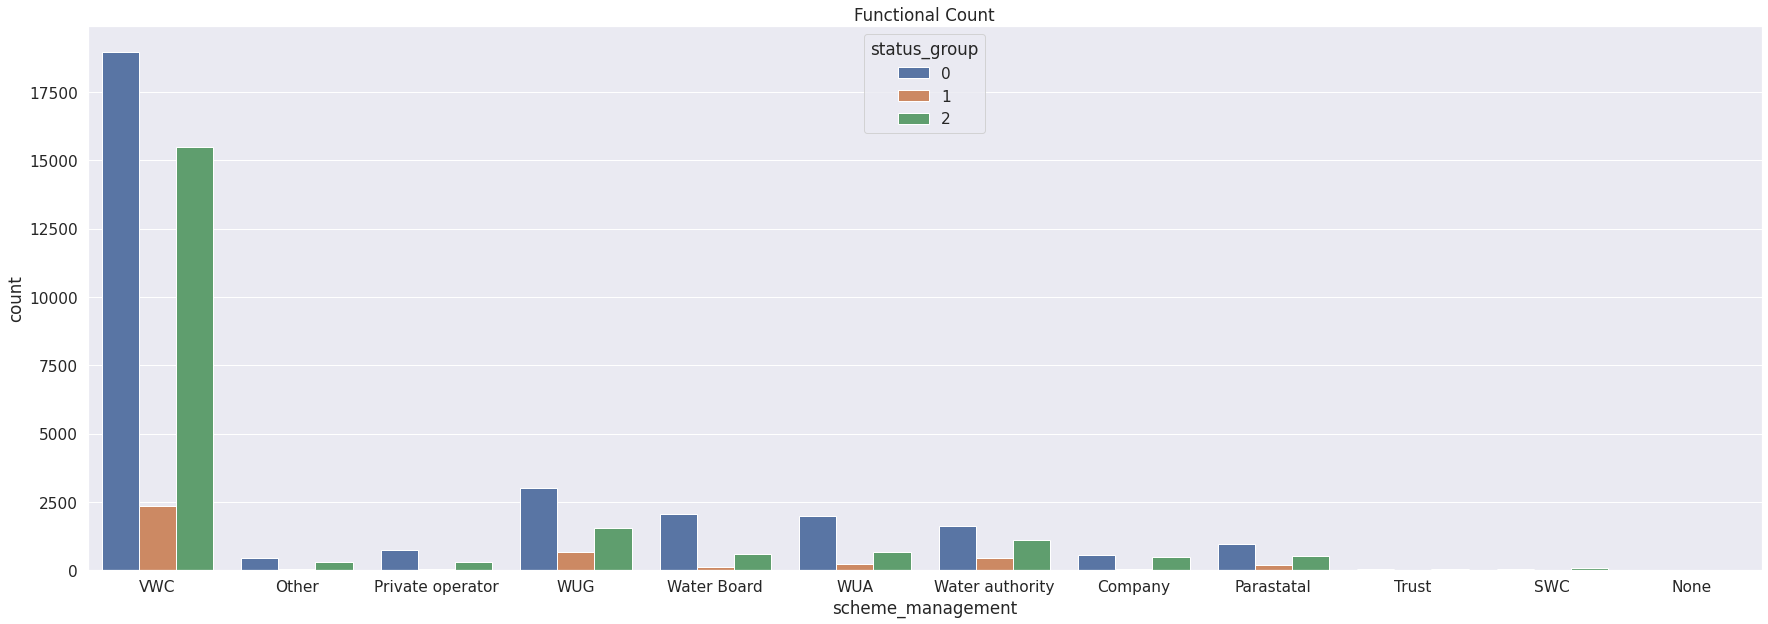

In [293]:
show_compare_countplot(df_train, "scheme_management","status_group", "Functional Count")

In [294]:
sch_mng = df_train.groupby(['region_code'])['scheme_management'].agg(pd.Series.mode)
sch_mng

region_code
1                  VWC
2                  VWC
3          Water Board
4                  VWC
5                  VWC
6                  VWC
7                  WUG
8                  VWC
9          Water Board
10                 VWC
11                 VWC
12                 VWC
13                 VWC
14                 VWC
15                 VWC
16                 VWC
17                 WUG
18                 VWC
19                 VWC
20                 VWC
21                 VWC
24                 VWC
40    Private operator
60                 VWC
80                 VWC
90                 VWC
99                 VWC
Name: scheme_management, dtype: object

#### scheme_name

In [295]:
df_train["scheme_name"].value_counts().to_frame()

scheme_name
K                                    682
None                                 644
Borehole                             546
Chalinze wate                        405
M                                    400
...                                  ...
NYA/ MAK/ BUK piped  scheme            1
Kigonigoni water supply                1
Bonde la mto Mara                      1
Mpin                                   1
Bujuruga Spring b                      1

[2696 rows x 1 columns]

In [296]:
sch_name = df_train.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
sch_name

region
Arusha             Machumba estate pipe line
Dar es Salaam                              J
Dodoma                                  Ntom
Iringa           wanging'ombe water supply s
Kagera                     Kaisho/Isingiro w
Kigoma                          Mkongoro Two
Kilimanjaro      Uroki-Bomang'ombe water sup
Lindi                    GEN Borehole Scheme
Manyara                               Kijiji
Mara                    Mradi wa maji Komuge
Mbeya                                      K
Morogoro                                  Ki
Mtwara                              Borehole
Mwanza                                  None
Pwani                          Chalinze wate
Rukwa                                      K
Ruvuma                                DANIDA
Shinyanga                               None
Singida                                    M
Tabora                            World Bank
Tanga                   Handeni Trunk Main(H
Name: scheme_name, dtype: object

In [297]:
df_train.groupby(['region_code'])['scheme_name'].agg(pd.Series.mode)

region_code
1                            Ntom
2       Machumba estate pipe line
3     Uroki-Bomang'ombe water sup
4            Handeni Trunk Main(H
5                              Ki
6                   Chalinze wate
7                               J
8                          Chiola
9                        Borehole
10                         DANIDA
11    wanging'ombe water supply s
12                              K
13                              M
14                     World Bank
15                              K
16                   Mkongoro Two
17                           None
18              Kaisho/Isingiro w
19                           None
20           Mradi wa maji Komuge
21                         Kijiji
24         Vyama vya watumia maji
40                             []
60            Vianzi Water Supply
80            GEN Borehole Scheme
90                         Mitema
99       Mbuo mkunwa water supply
Name: scheme_name, dtype: object

In [298]:
sch_name_mng = df_train.groupby(['scheme_management'])['scheme_name'].agg(pd.Series.mode)
sch_name_mng

scheme_management
Company                           Bagamoyo wate
None                                         []
Other                           Mshiri pipeline
Parastatal                                 None
Private operator          Mradi wa maji Shirati
SWC                                          []
Trust                                    Kenswa
VWC                                           K
WUA                               Chalinze wate
WUG                                        None
Water Board                            Borehole
Water authority     Ngana water supplied scheme
Name: scheme_name, dtype: object

### Feature Engineering and Pre Processing

In [299]:
df_train.corr()

id  amount_tsh  gps_height  longitude  latitude  \
id                 1.000000   -0.005321   -0.004692  -0.001348  0.001718   
amount_tsh        -0.005321    1.000000    0.076650   0.022134 -0.052670   
gps_height        -0.004692    0.076650    1.000000   0.149155 -0.035751   
longitude         -0.001348    0.022134    0.149155   1.000000 -0.425802   
latitude           0.001718   -0.052670   -0.035751  -0.425802  1.000000   
num_private       -0.002629    0.002944    0.007237   0.023873  0.006837   
region_code       -0.003028   -0.026813   -0.183521   0.034197 -0.221018   
district_code     -0.003044   -0.023599   -0.171233   0.151398 -0.201020   
population        -0.002813    0.016288    0.135003   0.086590 -0.022152   
construction_year -0.002082    0.067915    0.658727   0.396732 -0.245278   
status_group       0.004049   -0.053702   -0.114029   0.004366 -0.014547   

                   num_private  region_code  district_code  population  \
id                   -0.002629    -0.003028      -0.003044   -0.002813   
amount_tsh            0.002944    -0.026813      -0.023599    0.016288   
gps_height            0.007237    -0.183521      -0.171233    0.135003   
longitude             0.023873     0.034197       0.151398    0.086590   
latitude              0.006837    -0.221018      -0.201020   -0.022152   
num_private           1.000000    -0.020377      -0.004478    0.003818   
region_code          -0.020377     1.000000       0.678602    0.094088   
district_code        -0.004478     0.678602       1.000000    0.061831   
population            0.003818     0.094088       0.061831    1.000000   
construction_year     0.026056     0.031724       0.048315    0.260910   
status_group         -0.005021     0.108640       0.065687   -0.017759   

                   construction_year  status_group  
id                         -0.002082      0.004049  
amount_tsh                  0.067915     -0.053702  
gps_height                  0.658727     -0.114029  
longitude                   0.396732      0.004366  
latitude                   -0.245278     -0.014547  
num_private                 0.026056     -0.005021  
region_code                 0.031724      0.108640  
district_code               0.048315      0.065687  
population                  0.260910     -0.017759  
construction_year           1.000000     -0.043342  
status_group               -0.043342      1.000000

#### Handle Null Values

In [300]:
null_val

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [301]:
df_train = df_train.drop(columns=['status_group'])
df_train = df_train.append(df_test)

In [302]:
#filling embarked nulls with mode
df_train['public_meeting'].fillna(df_train['public_meeting'].mode()[0], inplace=True)

In [303]:
df_train['permit'].fillna(df_train['permit'].mode()[0], inplace=True)

In [304]:
df_train['installer'].fillna(df_train['installer'].mode()[0], inplace=True)
df_train['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [305]:
df_train['funder'].fillna(df_train['funder'].mode()[0], inplace=True)
df_train['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [306]:
df_train.loc[df_train['scheme_management'].isnull(),['scheme_management']] = df_train[df_train['scheme_management'].isnull()].apply(lambda row: sch_mng.loc[row['region_code']][0],axis=1)
df_train.loc[df_train['subvillage'].isnull(),['subvillage']] = df_train[df_train['subvillage'].isnull()].apply(lambda row: sub_vil.loc[row['region_code']][0],axis=1)
df_train.loc[df_train['scheme_name'].isnull(),['scheme_name']] = df_train[df_train['scheme_name'].isnull()].apply(lambda row: sch_name.loc[row['region']][0],axis=1)

In [307]:
df_train['gps_height']=df_train['gps_height'].mask(df_train['gps_height']==0).fillna(df_train['gps_height'].mean())
df_train['amount_tsh']=df_train['amount_tsh'].mask(df_train['amount_tsh']==0).fillna(df_train['amount_tsh'].mean())

In [308]:
df_train.loc[df_train['longitude'] == 0,['latitude', 'longitude']] = df_train[df_train['longitude']==0].apply(lambda row: df_train.groupby(['region_code'])[['latitude', 'longitude']].mean().loc[row['region_code'],['latitude', 'longitude']],axis=1)[['latitude', 'longitude']]

In [309]:
df_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

In [310]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 74250 non-null  object 
 4   gps_height             74250 non-null  float64
 5   installer              74250 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             74250 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

#### Handle Categorical Values

In [311]:
#cetegorical data to ints
label = LabelEncoder()

df_train['basin'] = label.fit_transform(df_train['basin'])
df_train['subvillage'] = label.fit_transform(df_train['subvillage'])
df_train['region'] = label.fit_transform(df_train['region'])
df_train['lga'] = label.fit_transform(df_train['lga'])
df_train['ward'] = label.fit_transform(df_train['ward'])
df_train['scheme_management'] = label.fit_transform(df_train['scheme_management'])
df_train['scheme_name'] = label.fit_transform(df_train['scheme_name'])
df_train['extraction_type'] = label.fit_transform(df_train['extraction_type'])
df_train['extraction_type_group'] = label.fit_transform(df_train['extraction_type_group'])
df_train['extraction_type_class'] = label.fit_transform(df_train['extraction_type_class'])
df_train['management'] = label.fit_transform(df_train['management'])
df_train['management_group'] = label.fit_transform(df_train['management_group'])
df_train['payment'] = label.fit_transform(df_train['payment'])
df_train['payment_type'] = label.fit_transform(df_train['payment_type'])
df_train['water_quality'] = label.fit_transform(df_train['water_quality'])
df_train['quality_group'] = label.fit_transform(df_train['quality_group'])
df_train['quantity'] = label.fit_transform(df_train['quantity'])
df_train['quantity_group'] = label.fit_transform(df_train['quantity_group'])
df_train['source'] = label.fit_transform(df_train['source'])
df_train['source_type'] = label.fit_transform(df_train['source_type'])
df_train['source_class'] = label.fit_transform(df_train['source_class'])
df_train['waterpoint_type'] = label.fit_transform(df_train['waterpoint_type'])
df_train['waterpoint_type_group'] = label.fit_transform(df_train['waterpoint_type_group'])
df_train['funder'] = label.fit_transform(df_train['funder'])
df_train['installer'] = label.fit_transform(df_train['installer'])
df_train['wpt_name'] = label.fit_transform(df_train['wpt_name'])

In [312]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 74250 non-null  int64  
 4   gps_height             74250 non-null  float64
 5   installer              74250 non-null  int64  
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  int64  
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  int64  
 11  subvillage             74250 non-null  int64  
 12  region                 74250 non-null  int64  
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

#### Remove Redundancy

In [313]:
#remove redunant columns
df_train = df_train.drop(columns=['id','date_recorded','recorded_by'])

In [314]:
from sklearn import preprocessing

x = df_train.values
min_max_scaler = preprocessing.MinMaxScaler()
columns = df_train.columns
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.DataFrame(x_scaled)
df_train.columns = columns

In [315]:
df_test = df_train[59400:]
df_train = df_train[:59400]

In [316]:
df_train.shape

(59400, 37)

In [317]:
df_train["status_group"] = train_label
df_train['status_group'] = label.fit_transform(df_train['status_group'])
df_train.shape

(59400, 38)

In [318]:
df_test.shape

(14850, 37)

In [319]:
df_train

amount_tsh    funder  gps_height  installer  longitude  latitude  \
0        0.017142  0.723235    0.516219   0.707641   0.648164  0.168353   
1        0.000910  0.243572    0.519358   0.252492   0.632591  0.892122   
2        0.000071  0.431510    0.270666   0.952658   0.812306  0.734967   
3        0.000910  0.916316    0.123125   0.862126   0.879034  0.046394   
4        0.000910  0.008883    0.263574   0.054402   0.400429  0.922364   
...           ...       ...         ...        ...        ...       ...   
59395    0.000028  0.226741    0.453436   0.094269   0.793380  0.788246   
59396    0.013428  0.091164    0.454133   0.123339   0.668459  0.242120   
59397    0.000910  0.236559    0.263574   0.182724   0.588235  0.272182   
59398    0.000910  0.463301    0.263574   0.563953   0.708237  0.494872   
59399    0.000910  0.984105    0.098012   0.949336   0.854170  0.460237   

       wpt_name  num_private  basin  subvillage  region  region_code  \
0      1.000000          0.0  0.125    0.612211    0.15     0.102041   
1      0.994374          0.0  0.500    0.821322    0.45     0.193878   
2      0.388919          0.0  0.625    0.471247    0.40     0.204082   
3      0.996804          0.0  0.875    0.466673    0.60     0.908163   
4      0.950266          0.0  0.500    0.400625    0.20     0.173469   
...         ...          ...    ...         ...     ...          ...   
59395  0.013856          0.0  0.625    0.294763    0.30     0.020408   
59396  0.644769          0.0  0.750    0.155106    0.15     0.102041   
59397  0.747214          0.0  0.750    0.456684    0.50     0.112245   
59398  0.794694          0.0  0.750    0.725962    0.10     0.000000   
59399  0.498873          0.0  1.000    0.306012    0.55     0.040816   

       district_code       lga      ward  population  public_meeting  \
0             0.0625  0.411290  0.681450    0.003574             1.0   
1             0.0250  0.830645  0.753934    0.009180             1.0   
2             0.0500  0.870968  0.776824    0.008197             1.0   
3             0.7875  0.701613  0.751550    0.001902             1.0   
4             0.0125  0.209677  0.806867    0.000000             1.0   
...              ...       ...       ...         ...             ...   
59395         0.0625  0.129032  0.520744    0.004098             1.0   
59396         0.0500  0.733871  0.168813    0.001836             1.0   
59397         0.0875  0.475806  0.084406    0.000000             1.0   
59398         0.0500  0.088710  0.692418    0.000000             1.0   
59399         0.0250  0.572581  0.770148    0.004918             1.0   

       scheme_management  scheme_name  permit  construction_year  \
0               0.615385     0.832636     0.0           0.993045   
1               0.153846     0.418759     1.0           0.998510   
2               0.615385     0.788354     1.0           0.998013   
3               0.615385     0.009066     1.0           0.986587   
4               0.538462     0.224547     1.0           0.000000   
...                  ...          ...     ...                ...   
59395           0.923077     0.399582     1.0           0.993045   
59396           0.615385     0.180265     1.0           0.991555   
59397           0.615385     0.224547     0.0           0.000000   
59398           0.615385     0.694561     1.0           0.000000   
59399           0.615385     0.224547     1.0           0.994536   

       extraction_type  extraction_type_group  extraction_type_class  \
0             0.176471               0.083333               0.000000   
1             0.176471               0.083333               0.000000   
2             0.176471               0.083333               0.000000   
3             0.823529               0.833333               0.833333   
4             0.176471               0.083333               0.000000   
...                ...                    ...                    ...   
59395         0.176471               0.083333          

### Feature Selection

#### Correlation

In [320]:
#correlation

plt.figure(figsize=(50,50))
plt.rcParams["axes.labelsize"] = 20
sns.set(font_scale=1.4)
sns.heatmap(df_train.corr(), annot = True ,linewidths=.1)
plt.show()

In [321]:
df_train = df_train.drop(columns=['quantity_group','extraction_type_group', 'waterpoint_type_group','status_group'])
df_test = df_test.drop(columns=['quantity_group','extraction_type_group', 'waterpoint_type_group'])

In [322]:
!pip install catboost

In [323]:
from catboost import CatBoostClassifier

In [324]:
model = CatBoostClassifier(
        max_ctr_complexity=5,
        task_type='CPU',
        iterations=1000,
        eval_metric='AUC',
        od_type='Iter',
        od_wait=500,
        verbose=False
)

In [325]:
#refines features
y = train_label
X = df_train

model.fit(X,y)

pred = model.predict(X)

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score

print("Accuracy Score: ", accuracy_score(y, pred))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Accuracy Score:  0.8315488215488216


### Modeling

In [ ]:
num_cols = ['amount_tsh','gps_height','longitude','latitude','num_private','region_code','district_code','population','construction_year']
cat_cols = ['funder','installer','wpt_name','basin','subvillage','region','lga','ward','public_meeting','scheme_management','scheme_name','permit','extraction_type','extraction_type_class','management','management_group','payment','payment_type','water_quality','quality_group','quantity','source','source_type','source_class','waterpoint_type']

#look into and missing numerical values
num_transform = SimpleImputer(strategy='median')

#look into and missing categorical values
cat_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessing data
preprocessor = ColumnTransformer(transformers=[('num', num_transform, num_cols),('cat', cat_transform, cat_cols)])

#modeling pipeline 
pump = Pipeline(steps=[('preprocessor', preprocessor),('model', CatBoostClassifier(
        max_ctr_complexity=5,
        task_type='CPU',
        iterations=1000,
        eval_metric='AUC',
        od_type='Iter',
        od_wait=500,
        verbose=False
))])

#fit the model
pump.fit(X,y)

score_train = pump.score(X,y)
print("Train Prediction Score",score_train*100)

#cross-validated test results
print('Cross validation score: {:.3f}'.format(cross_val_score(pump, X, y, cv=10).mean()))

### Results

In [ ]:
#make predictions
predictions = pump.predict(df_test)

output = pd.DataFrame({'id': test.id, 'status_group': pred.flat})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")